## 224 x 224 version ##


In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm
from PIL import Image

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from collections import OrderedDict

from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR


In [269]:
test_dir = 'category_train'
categories = os.listdir(test_dir)
print(categories)

['0-T-shirt', '1-TrouserJeans', '2-Pullover', '3-Dress', '4-CoatJacket', '5-Sandal', '6-Shirt', '7-Shoes', '8-Bag', '9-Ankle Boot']


In [270]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize((224, 224)),
                                transforms.Normalize((0.5,), (0.5,))])

train_ds = datasets.FashionMNIST('F_MNIST_data', download=True, train=True, transform=transform)
#test_ds = datasets.FashionMNIST('F_MNIST_data', download=True, train=False, transform=transform)


In [271]:
# split train set into training (80%) and validation set (20%)
train_num = len(train_ds)
indices = list(range(train_num))
np.random.shuffle(indices)
split = int(np.floor(0.2 * train_num))
val_idx, train_idx = indices[:split], indices[split:]
len(val_idx), len(train_idx)

(12000, 48000)

In [272]:
# prepare dataloaders
train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_idx)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=64, sampler=train_sampler)
val_sampler = torch.utils.data.sampler.SubsetRandomSampler(val_idx)
val_dl = torch.utils.data.DataLoader(train_ds, batch_size=64, sampler=val_sampler)
#test_dl = torch.utils.data.DataLoader(test_ds, batch_size=64, shuffle=True)

torch.Size([1, 224, 224]) torch.Size([64])
0-T-shirt


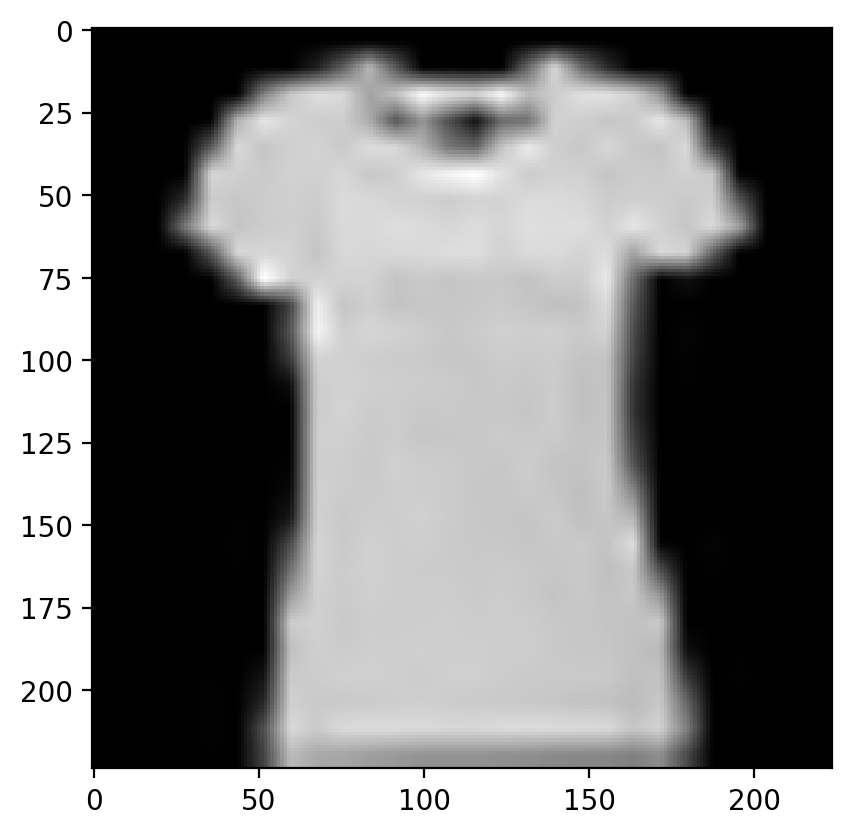

In [273]:
image, label = next(iter(train_dl))
print(image[0].shape, label.shape)
desc = categories
print(desc[label[0].item()])
plt.imshow(image[0].numpy().squeeze(), cmap='gray');

In [274]:
flattened_size = 64 * 224 * 224 * 3
flattened_size

9633792

In [275]:
def network():
    model = nn.Sequential(OrderedDict([
        ('flatten', nn.Flatten()),  # Flatten the input image (move this to the beginning)
        ('fc1', nn.Linear(50176, 512)),  # Adjust the input size
        ('relu1', nn.ReLU()),
        ('drop1', nn.Dropout(0.25)),
        ('fc2', nn.Linear(512, 256)),
        ('relu2', nn.ReLU()),
        ('drop2', nn.Dropout(0.25)),
        ('output', nn.Linear(256, 10)),
        ('logsoftmax', nn.LogSoftmax(dim=1))
    ]))
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)

    # define the criterion and optimizer
    loss_fn = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    return model, loss_fn, optimizer, device                      

In [276]:
model, loss_fn, optimizer, device = network()
print(model)

Sequential(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=50176, out_features=512, bias=True)
  (relu1): ReLU()
  (drop1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (relu2): ReLU()
  (drop2): Dropout(p=0.25, inplace=False)
  (output): Linear(in_features=256, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
)


In [277]:
num_labels = len(categories)

category_to_label = {
    colour: idx for idx, colour in enumerate(categories)
}

label_to_category = {
    idx: colour for idx, colour in enumerate(categories)
}

print(num_labels)
print(category_to_label)
print(label_to_category)


10
{'0-T-shirt': 0, '1-TrouserJeans': 1, '2-Pullover': 2, '3-Dress': 3, '4-CoatJacket': 4, '5-Sandal': 5, '6-Shirt': 6, '7-Shoes': 7, '8-Bag': 8, '9-Ankle Boot': 9}
{0: '0-T-shirt', 1: '1-TrouserJeans', 2: '2-Pullover', 3: '3-Dress', 4: '4-CoatJacket', 5: '5-Sandal', 6: '6-Shirt', 7: '7-Shoes', 8: '8-Bag', 9: '9-Ankle Boot'}


In [278]:
from PIL import ImageOps

class ImageLoader:
    def __init__(self):
        self.transform = transforms.Compose( # chain sequence of image transformations together
            [
                transforms.Resize((224, 224)), # resize it to a square of 28x28
                transforms.Grayscale(num_output_channels=1),  # Convert to black and white
                transforms.ToTensor(), # converts this to a pytorch tensor; these tensors are pivotal to pytorch neural networking
                transforms.Normalize(mean=[0.485], std=[0.229]), # normalizes the pixel value of the image
            ]
        )
        
    def load(self, img_path): # uses Python Imaging Library (PIL) to open image
        img = Image.open(img_path).convert('L') # open image and convert to grayscale
        inverted_img = ImageOps.invert(img)  # Invert the colours
        t_img = self.transform(inverted_img) # transform the image defined above
        return t_img


In [279]:
class ImageDataset(Dataset):

    train_data_dir = 'category_train'

    def __init__ (self, image_loader):
        categories = os.listdir(self.train_data_dir)

        self.data = []

        for category in tqdm(categories):
            image_fnames = [i for i in os.listdir(f'{self.train_data_dir}/{category}') if not i.startswith('.')]
            for image_fname in image_fnames:
                img_path = f'{self.train_data_dir}/{category}/{image_fname}'
                t_img = image_loader.load(img_path)
                label = category_to_label[category]
                self.data.append((t_img, label))

    def __len__(self):
        return len(self.data)
        
    def __getitem__(self, idx):
        return self.data[idx]


In [280]:
dataset = ImageDataset(ImageLoader()) # my own images

100%|██████████| 10/10 [00:00<00:00, 53.65it/s]


In [281]:
dataset

In [282]:
val_ratio = 0.2
test_size = 10

val_size = int(len(dataset) * val_ratio)
train_size = len(dataset) - (val_size + test_size)

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size]) # X_train, y_train, ytest


In [283]:
len(test_dataset)

10

In [284]:
test_dl = DataLoader(test_dataset, batch_size = 64, shuffle = True)

In [285]:
def plot_metrics(epochs, train_metric, val_metric, metric_name, ylabel, title):
    plt.plot(range(1, epochs+1), train_metric)
    plt.plot(range(1, epochs+1), val_metric)
    plt.legend([f'train_{metric_name}', f'val_{metric_name}'])
    plt.xticks(1, range(epochs+1))
    plt.xlabel('Epochs')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)
    plt.show()

In [286]:
import time

def train_validate(model, loss_fn, optimizer, trainloader, testloader, device, n_epochs=10):
    train_losses, test_losses = [], []
    train_acc_list, test_acc_list = [], []
    start_time = time.time()  # Record the start time for the epoch
    for epoch in range(n_epochs):
        # Set mode to training - Dropouts will be used here
        model.train()
        train_loss = 0
        train_acc = 0  # Initialize train_epoch_acc here

        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            # flatten the images to batch_size
            images = images.view(images.shape[0], -1)
            # forward pass
            outputs = model(images)
            # backpropogation
            train_batch_loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            train_batch_loss.backward()
            # Weight updates
            optimizer.step()
            train_loss += train_batch_loss.item()

            # Calculate training accuracy
            _, predicted_labels = torch.max(outputs, 1)
            correct_predictions = (predicted_labels == labels).sum().item()
            total_samples = labels.size(0)
            train_batch_acc = correct_predictions / total_samples
            
            train_loss += train_batch_loss.item()
            train_acc += train_batch_acc
            
        else:
            # One epoch of training complete
            # calculate average training epoch loss
            train_loss = train_loss/len(trainloader)

            # Now Validate on testset
            with torch.no_grad():
                test_acc = 0
                test_loss = 0
                # Set mode to eval - Dropouts will NOT be used here
                model.eval()
                for images, labels in testloader:
                    images, labels = images.to(device), labels.to(device)                    
                    # flatten images to batch_size
                    images = images.view(images.shape[0], -1)
                    # make predictions 
                    test_outputs = model(images)
                    # calculate test loss
                    test_batch_loss = loss_fn(test_outputs, labels)
                    test_loss += test_batch_loss
                    
                    # get probabilities, extract the class associated with highest probability
                    proba = torch.exp(test_outputs)
                    _, pred_labels = proba.topk(1, dim=1)
                    
                    # compare actual labels and predicted labels
                    result = pred_labels == labels.view(pred_labels.shape)
                    batch_acc = torch.mean(result.type(torch.FloatTensor))
                    test_acc += batch_acc.item()
                else:
                    # One epoch of training and validation done
                    # calculate average testing epoch loss
                    test_loss = test_loss/len(testloader)
                    # calculate accuracy as correct_pred/total_samples
                    test_acc = test_acc/len(testloader)
                    train_acc = train_acc / len(trainloader)
                    # save epoch losses for plotting
                    train_losses.append(train_loss)
                    test_losses.append(test_loss)
                    train_acc_list.append(train_acc)
                    test_acc_list.append(test_acc)

                    # print stats for this epoch
                    print(f'Epoch: {epoch+1} -> train_loss: {train_loss:.2f}, val_loss: {test_loss:.2f}, ',
                          f'train_acc: {train_acc*100:.2f}%, val_acc: {test_acc*100:.2f}%')



    plot_metrics(n_epochs, train_losses, test_losses, 'loss', 'Losses', 'Losses over Epochs')    

    plot_metrics(n_epochs, train_acc_list, test_acc_list, 'accuracy', 'Accuracy', 'Accuracy over Epochs')

    
    end_time = time.time()  # Record the end time for the epoch
    elapsed_time = end_time - start_time  # Calculate the elapsed time   
    minutes = int(elapsed_time//60.0)
    seconds = elapsed_time % 60

    print(f'Model Runtime: {minutes} minutes {seconds:.2f}seconds') 
                


def train_validate(model, loss_fn, optimizer, trainloader, testloader, device, n_epochs=25):
    train_losses, val_losses = [], []
    train_acc, val_acc = [], []
    for epoch in range(n_epochs):
        # Set mode to training - Dropouts will be used here
        model.train()
        train_loss = 0
        val_loss = 0
        train_corrects = 0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            # flatten the images to batch_size x 784
            images = images.view(images.shape[0], -1)

            # forward pass
            outputs = model(images)

            # backpropogation
            train_batch_loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            train_batch_loss.backward()

            # Weight updates
            optimizer.step()

            train_loss += train_batch_loss.item()

            _, predicted = torch.max(outputs.data, 1)

            train_corrects += (predicted == labels).sum().item()
            
        else:
            # One epoch of training complete
            # calculate average training epoch loss
            train_loss = train_loss/len(trainloader)
            train_acc = train_corrects/len(trainloader.dataset)

            # Now Validate on testset
            with torch.no_grad():
                val_acc = 0 # validation accuracy
                val_loss = 0 # validation loss
                # Set mode to eval - Dropouts will NOT be used here
                model.eval()
                for images, labels in testloader:
                    images, labels = images.to(device), labels.to(device)                    
                    # flatten images to batch_size x 784
                    images = images.view(images.shape[0], -1)
                    # make predictions 
                    test_outputs = model(images)
                    # calculate test loss
                    test_batch_loss = loss_fn(test_outputs, labels)
                    val_loss += test_batch_loss
                    
                    # get probabilities, extract the class associated with highest probability
                    proba = torch.exp(test_outputs)
                    _, pred_labels = proba.topk(1, dim=1)
                    
                    # compare actual labels and predicted labels
                    result = pred_labels == labels.view(pred_labels.shape)
                    batch_acc = torch.mean(result.type(torch.FloatTensor))
                    val_acc += batch_acc.item()
                else:
                    # One epoch of training and validation done
                    # calculate average testing epoch loss
                    val_loss = val_loss/len(testloader)
                    # calculate accuracy as correct_pred/total_samples
                    val_acc = val_acc/len(testloader.dataset)
                    # save epoch losses for plotting
                    train_losses.append(train_loss)
                    val_losses.append(val_loss)
                    # print stats for this epoch
                    print(f'epoch={epoch + 1}, train_loss={train_loss:.3f}, val_loss={val_loss:.3f}, train_accuracy={train_acc:.3f}, val_accuracy={val_acc:.3f}')


In [173]:
val_dl

Epoch: 1 -> train_loss: 1.54, val_loss: 0.47,  train_acc: 74.77%, val_acc: 83.58%
Epoch: 2 -> train_loss: 1.11, val_loss: 0.42,  train_acc: 80.10%, val_acc: 84.90%
Epoch: 3 -> train_loss: 1.05, val_loss: 0.45,  train_acc: 81.20%, val_acc: 83.88%
Epoch: 4 -> train_loss: 1.01, val_loss: 0.43,  train_acc: 82.03%, val_acc: 83.88%
Epoch: 5 -> train_loss: 1.00, val_loss: 0.40,  train_acc: 82.34%, val_acc: 85.26%


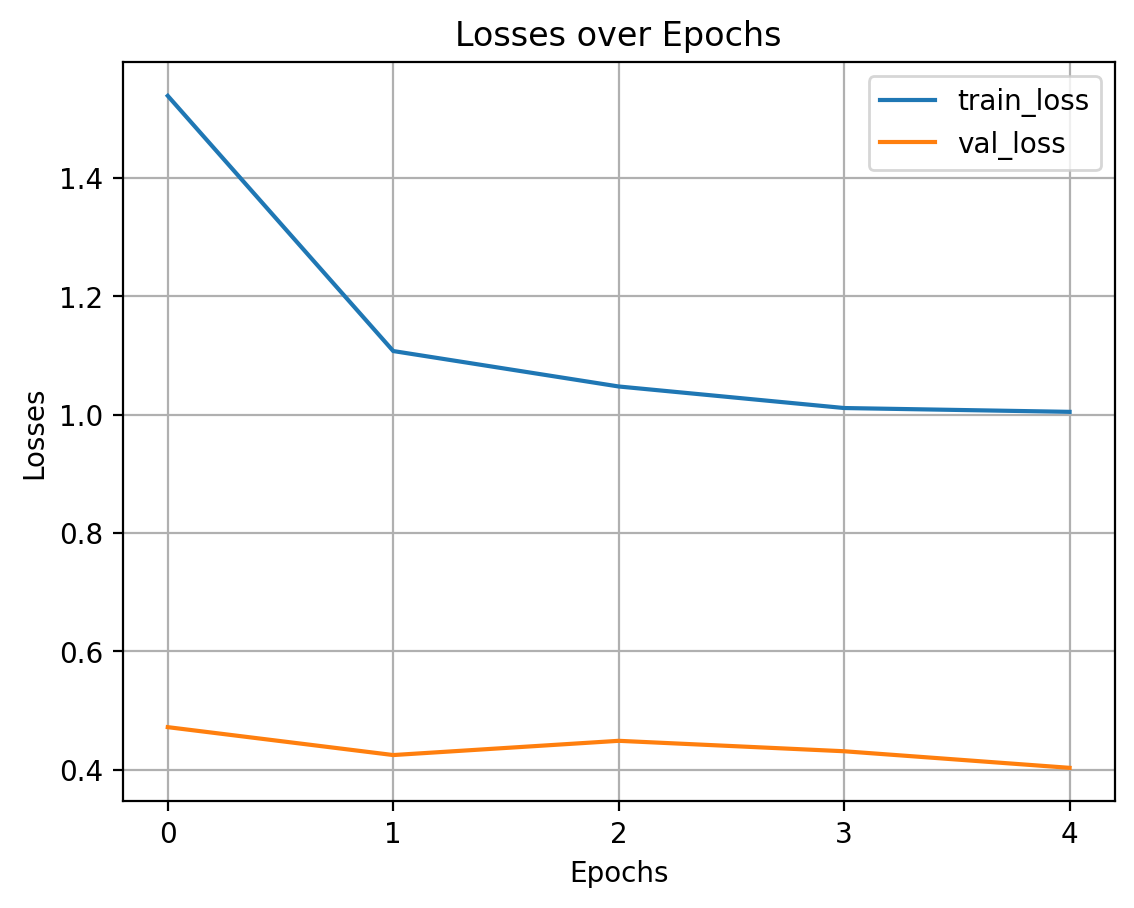

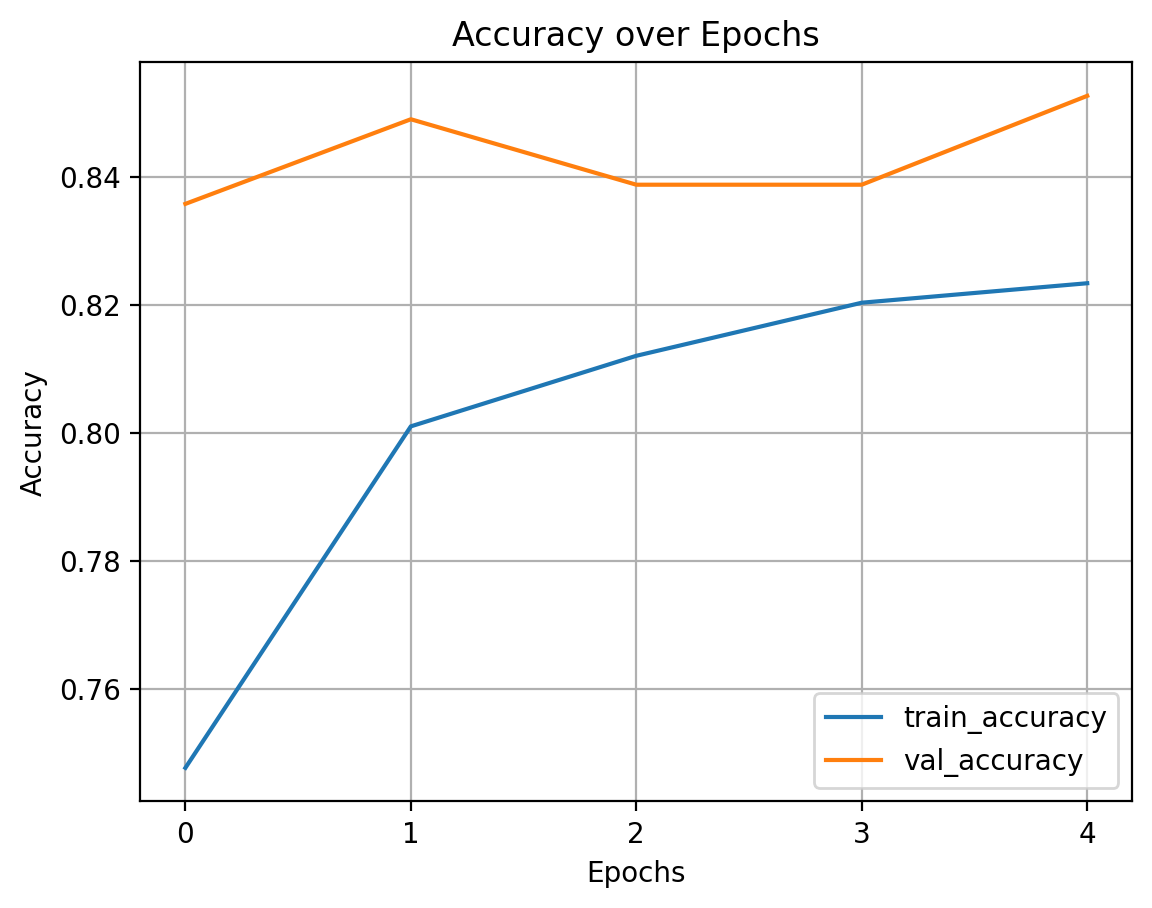

Model Runtime: 657.68 seconds


In [174]:

train_validate(model, loss_fn, optimizer, train_dl, val_dl, device)

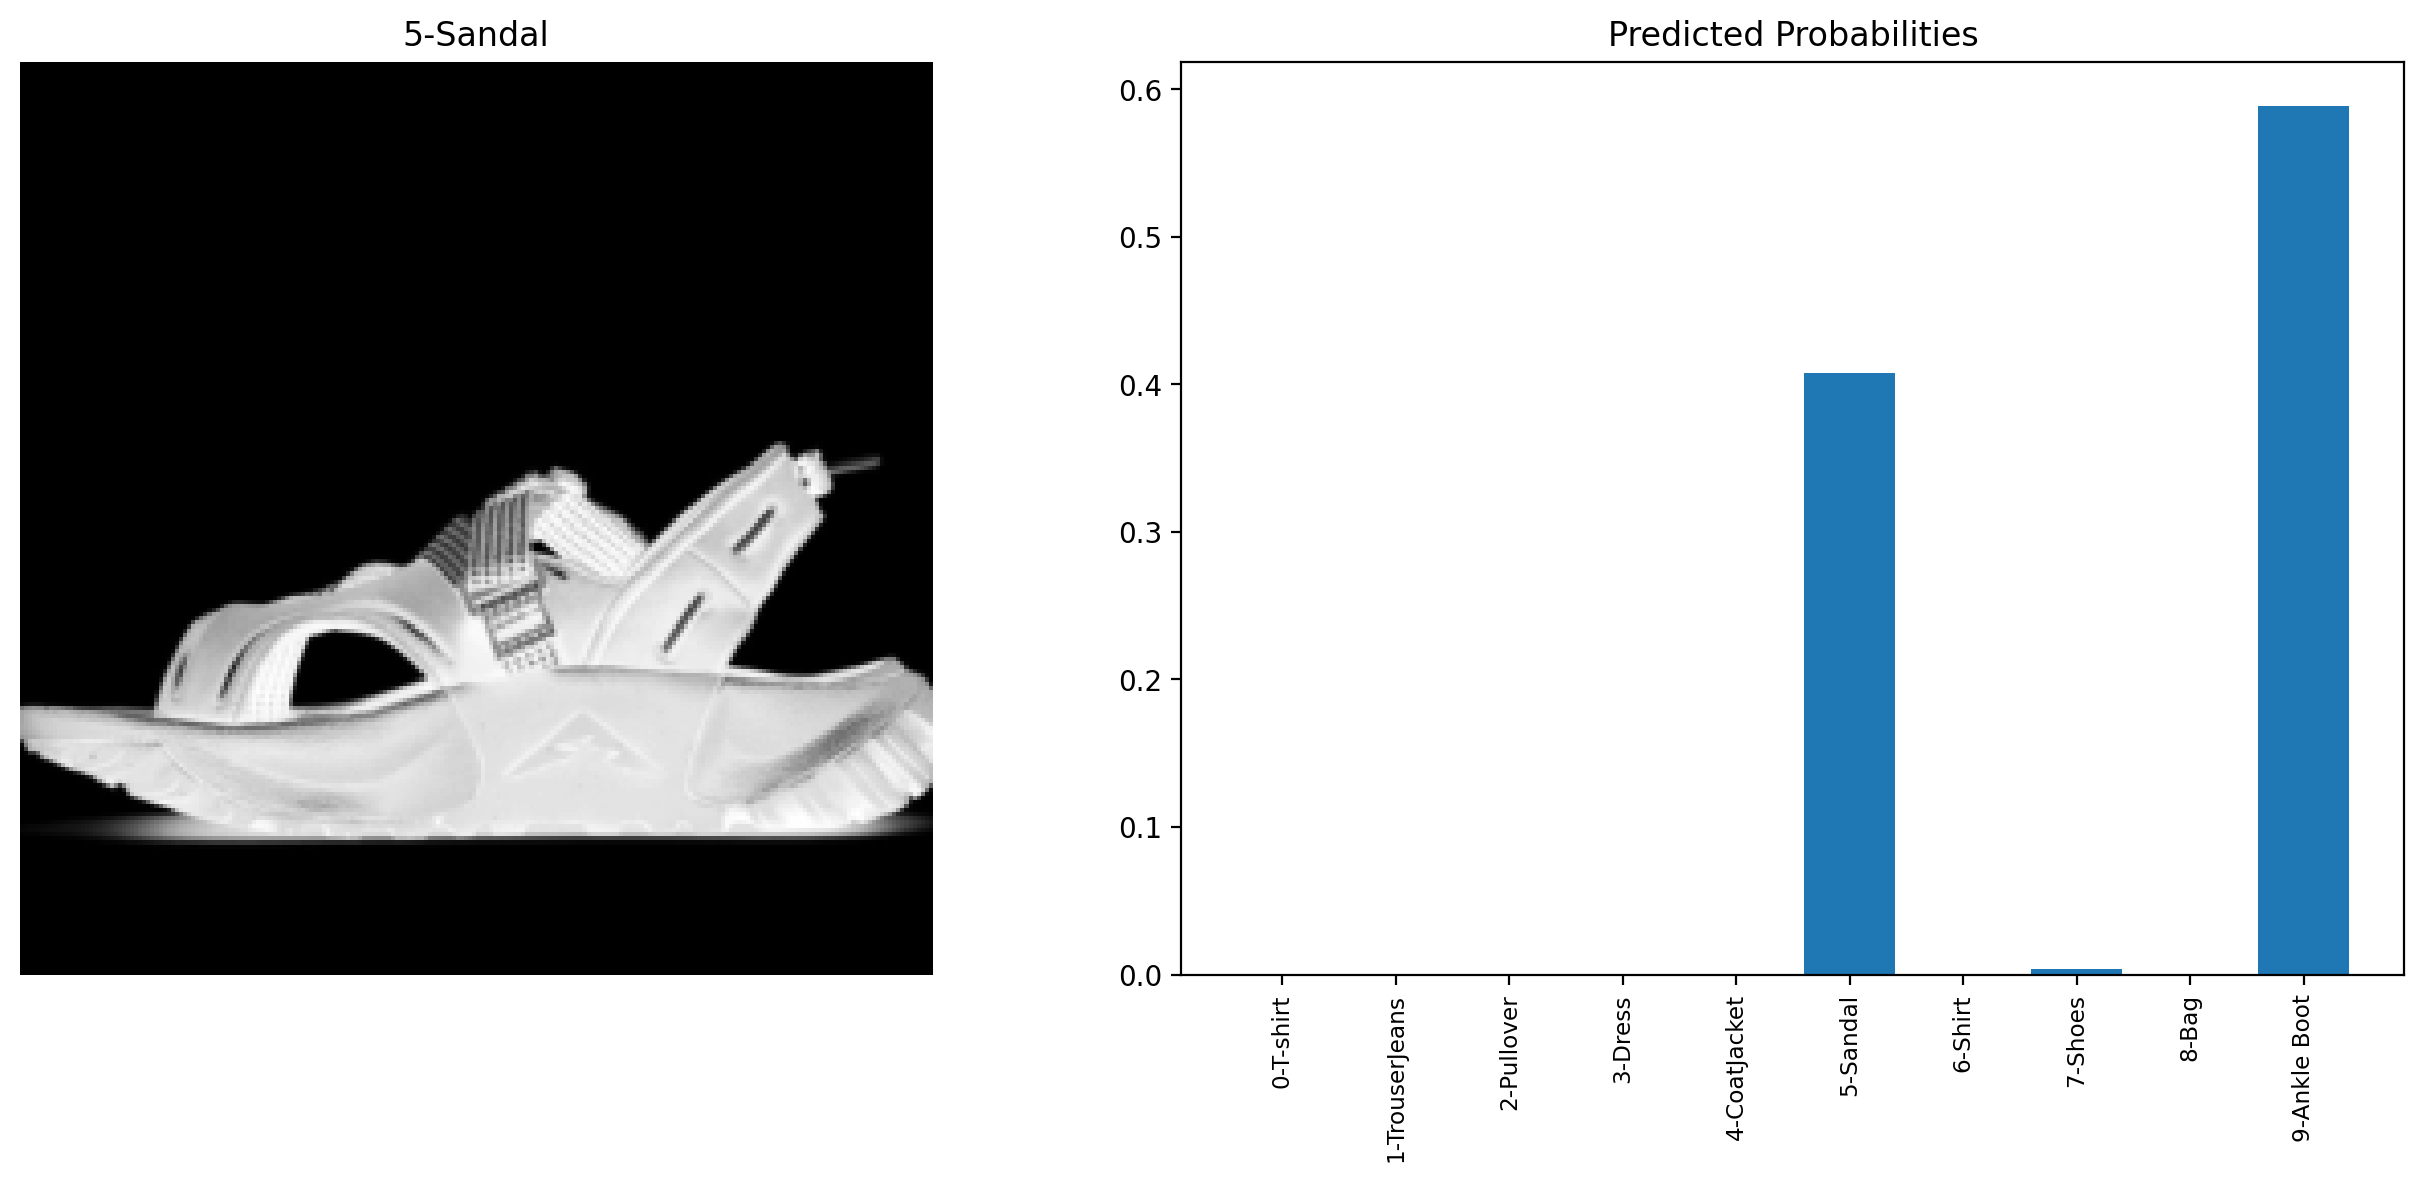

The model predicts it is a 9-Ankle Boot with a probability of 58.88% certainty


In [268]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Assuming test_dl is a DataLoader object
for images, labels in test_dl:
    images, labels = images.to(device), labels.to(device)
    index = 4
    img, label = images[index], labels[index]
    
    # Convert 2D image to 1D vector
    img = img.view(img.shape[0], -1)

    # Calculate the class probabilities (softmax) for img
    proba = torch.exp(model(img))

    # Plot the image and probabilities
    desc = categories
    fig, (ax1, ax2) = plt.subplots(figsize=(13, 6), nrows=1, ncols=2)
    ax1.axis('off')
    ax1.imshow(images[index].cpu().numpy().squeeze(), cmap='gray')  # Specify 'gray' colormap
    ax1.set_title(desc[label.item()])
    ax2.bar(range(10), proba.detach().cpu().numpy().squeeze(), align='center')
    ax2.set_xticks(range(10))
    ax2.set_xticklabels(desc, size='small', rotation = 'vertical')
    ax2.set_title('Predicted Probabilities')
    plt.tight_layout()
    plt.show()
    max_value = max(proba.detach().cpu().numpy().squeeze())
    max_index = np.argmax(proba.detach().cpu().numpy().squeeze())

    print(f'The model predicts it is a {categories[max_index]} with a probability of {max_value*100:.2f}% certainty')

    break  # Break the loop after processing one batch if you just want to visualize one example


## THIS ONE WORKS WITH MNIST ##


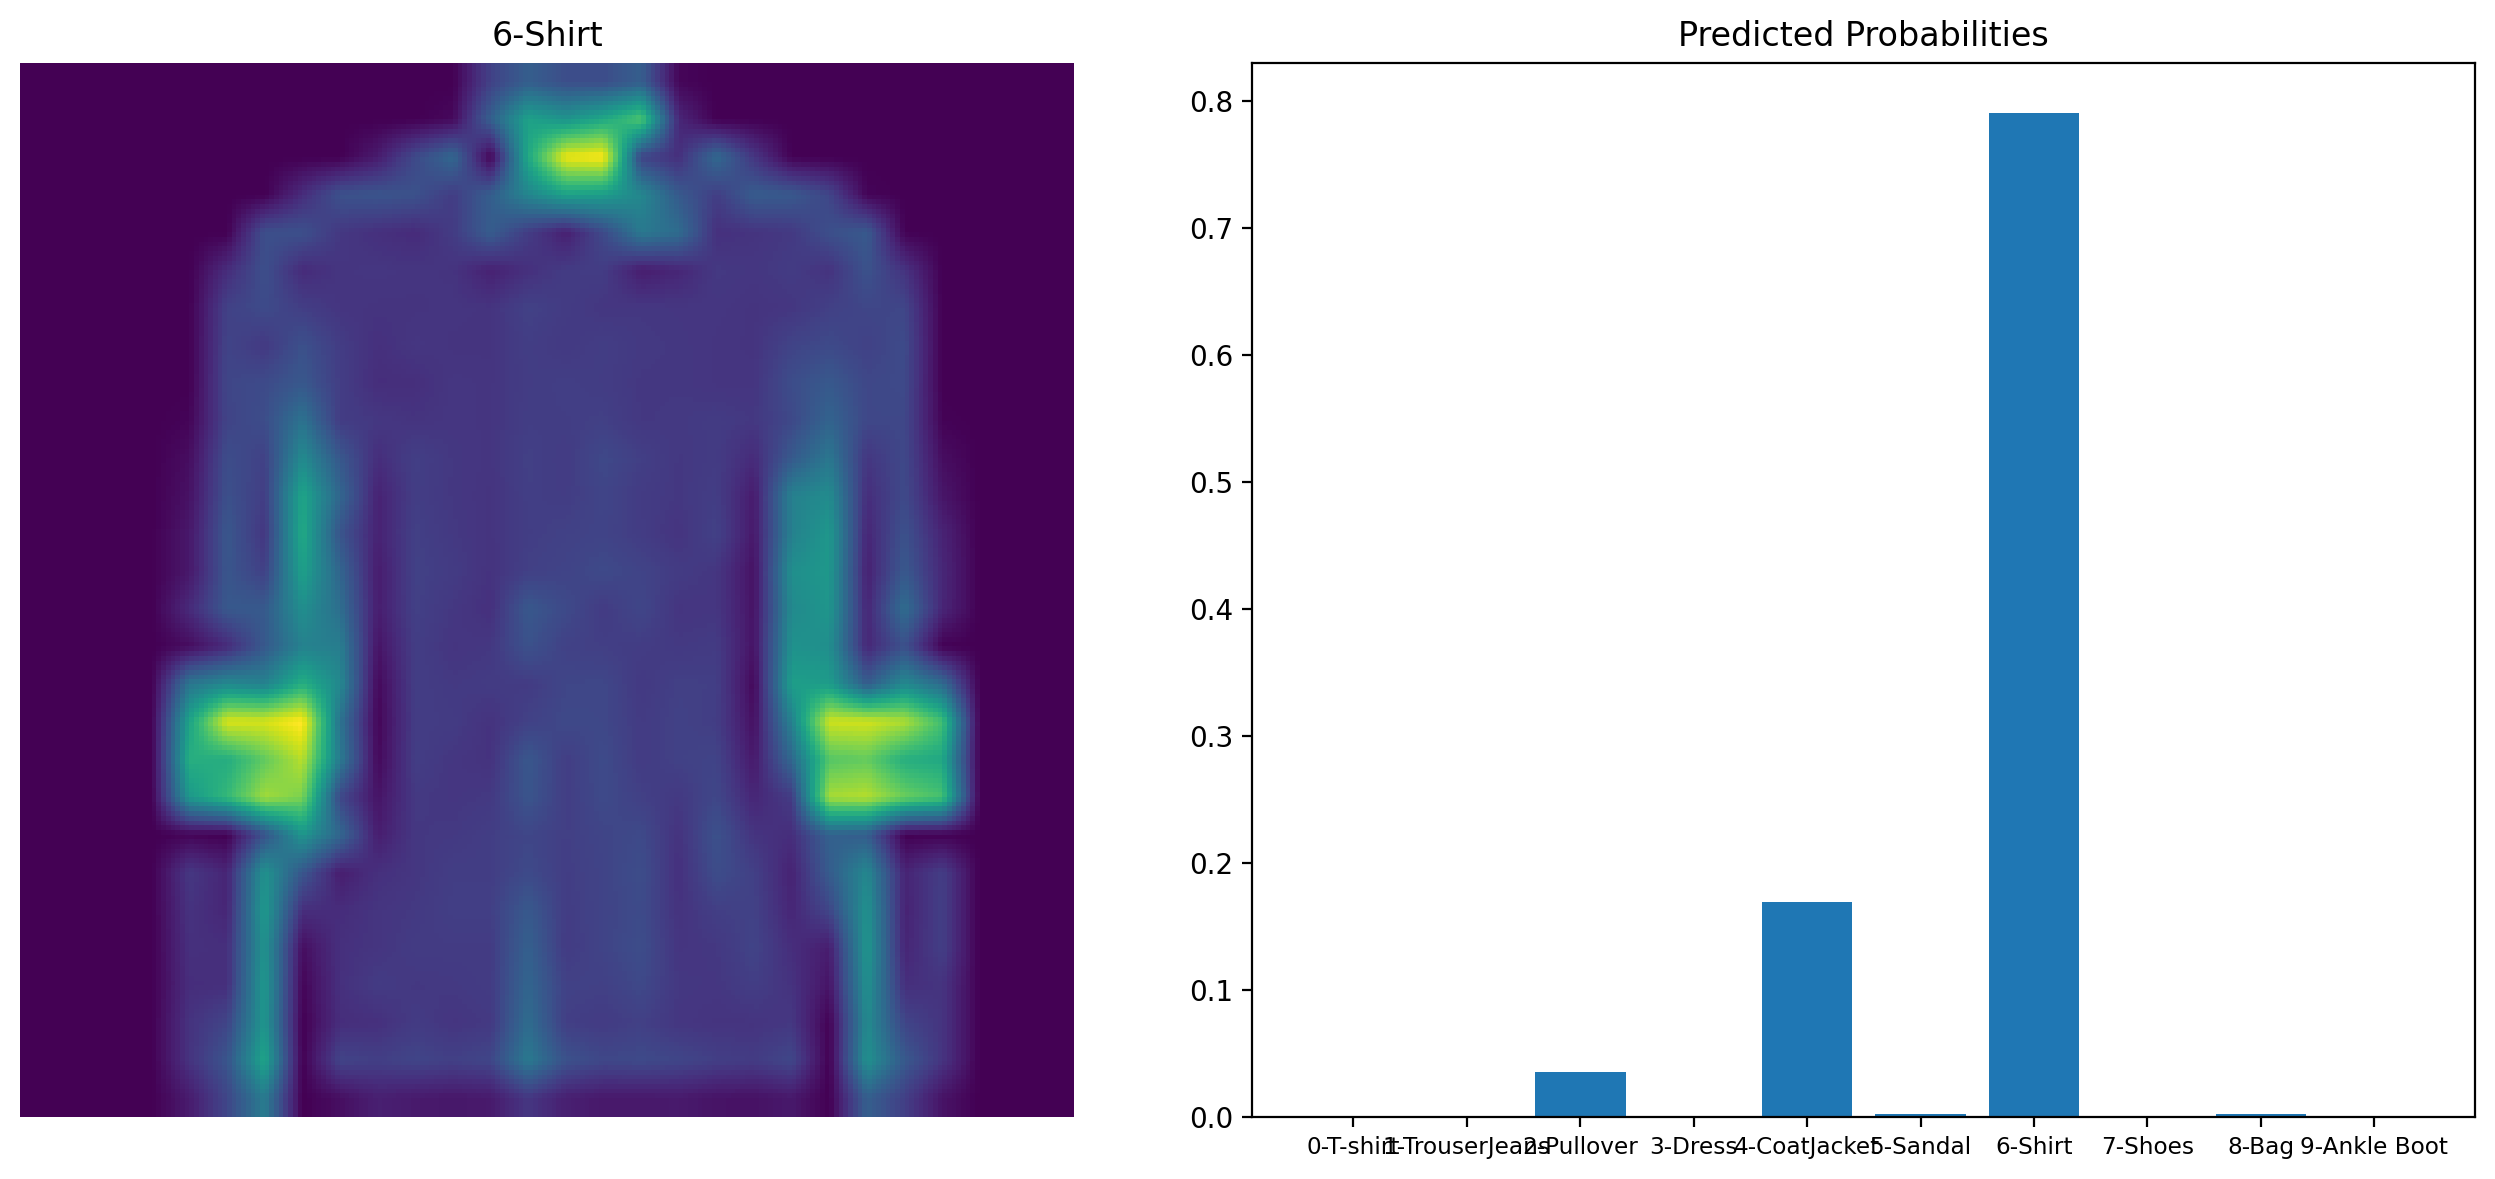

In [40]:
## ORIGINAL THAT WORKS WITH MNIST

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Assuming test_dl is a DataLoader object
for images, labels in test_dl:
    images, labels = images.to(device), labels.to(device)
    index = 29
    img, label = images[index], labels[index]
    
    # Convert 2D image to 1D vector
    img = img.view(img.shape[0], -1)

    # Calculate the class probabilities (softmax) for img
    proba = torch.exp(model(img))

    # Plot the image and probabilities
    desc = categories
    fig, (ax1, ax2) = plt.subplots(figsize=(13, 6), nrows=1, ncols = 2)
    ax1.axis('off')
    ax1.imshow(images[index].cpu().numpy().squeeze())
    ax1.set_title(desc[label.item()])
    ax2.bar(range(10), proba.detach().cpu().numpy().squeeze())
    ax2.set_xticks(range(10))
    ax2.set_xticklabels(desc, size='small')
    ax2.set_title('Predicted Probabilities')
    plt.tight_layout()
    plt.show()
    break  # Break the loop after processing one batch if you just want to visualize one example

In [22]:
desc

['0-T-shirt',
 '1-TrouserJeans',
 '2-Pullover',
 '3-Dress',
 '4-CoatJacket',
 '5-Sandal',
 '6-Shirt',
 '7-Shoes',
 '8-Bag',
 '9-Ankle Boot']

In [22]:
# Assuming test_dl is a DataLoader object
for batch in test_dl:
    images, labels = batch[0].to(device), batch[1].to(device)
    
    for index in range(len(images)):
        img, label = images[index], labels[index]
        
        # Convert 2D image to 1D vector
        img = img.view(img.shape[0], -1)

        # Calculate the class probabilities (softmax) for img
        proba = torch.exp(model(img))

        # Get the predicted class
        predicted_class = torch.argmax(proba).item()

        # Plot the image and probabilities
        desc = categories

        category = random.choice(categories)

        test_label = category_to_label[category]

        fig, (ax1) = plt.subplots(figsize=(13, 6), nrows=1)
        ax1.axis('off')

        # Normalize the image data if needed
        img_data = images[index].cpu().numpy().transpose(1, 2, 0)  # Transpose to (height, width, channels)

        # Ensure the image data is in the valid range [0, 1] for imshow
        img_data = img_data.clip(0, 1)

        ax1.imshow(img_data)
        ax1.set_title(f"Actual: {desc[label]}, Predicted: {desc[predicted_class]}")

        print(proba)
        predicted_class = torch.argmax(proba).item()
        print(f"Predicted class: {predicted_class}")
    
        # Uncomment the next line if you want to visualize only one example
        # break  # Break the loop after processing one image if you just want to visualize one example


tensor([[7.8061e-01, 4.8559e-05, 4.4927e-03, 8.6341e-04, 5.4037e-05, 7.3640e-06,
         2.1339e-01, 1.7223e-07, 5.3643e-04, 3.4935e-07]],
       grad_fn=<ExpBackward0>)
Predicted class: 0
tensor([[1.4380e-06, 4.7915e-09, 2.6804e-07, 7.2284e-08, 2.7473e-07, 9.9827e-01,
         3.9066e-06, 1.6018e-03, 9.9586e-05, 2.5595e-05]],
       grad_fn=<ExpBackward0>)
Predicted class: 5
tensor([[2.5719e-05, 7.4515e-05, 1.4451e-04, 2.1306e-04, 8.5979e-05, 3.2061e-02,
         8.0245e-05, 7.8037e-01, 8.6135e-03, 1.7833e-01]],
       grad_fn=<ExpBackward0>)
Predicted class: 7
tensor([[1.7998e-02, 3.0334e-04, 8.4171e-01, 8.2167e-04, 1.2974e-02, 5.2953e-05,
         1.2586e-01, 2.2437e-06, 2.7230e-04, 9.3032e-07]],
       grad_fn=<ExpBackward0>)
Predicted class: 2
tensor([[5.7133e-02, 5.4437e-02, 1.4195e-01, 3.5457e-01, 3.1265e-01, 2.4406e-03,
         7.2549e-02, 7.0350e-04, 3.3717e-03, 1.9853e-04]],
       grad_fn=<ExpBackward0>)
Predicted class: 3
tensor([[2.0074e-07, 1.0000e+00, 6.4665e-10, 6.989

C:\Users\Katarina\AppData\Local\Temp\ipykernel_29624\2782964274.py:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, (ax1) = plt.subplots(figsize=(13, 6), nrows=1)


tensor([[1.5849e-02, 4.8342e-03, 7.6898e-05, 9.7596e-01, 7.7567e-04, 2.0082e-06,
         2.4603e-03, 5.8871e-08, 4.4681e-05, 5.0930e-09]],
       grad_fn=<ExpBackward0>)
Predicted class: 3
tensor([[6.9789e-09, 8.0388e-11, 2.0538e-10, 9.6485e-09, 2.5178e-11, 1.8868e-03,
         6.0410e-08, 8.9044e-03, 1.5218e-07, 9.8921e-01]],
       grad_fn=<ExpBackward0>)
Predicted class: 9
tensor([[1.2682e-07, 3.0462e-10, 2.9998e-08, 5.8981e-09, 1.8760e-08, 9.9780e-01,
         2.7876e-07, 2.1572e-03, 2.7512e-05, 1.3836e-05]],
       grad_fn=<ExpBackward0>)
Predicted class: 5
tensor([[0.2127, 0.0300, 0.1734, 0.2404, 0.0962, 0.0064, 0.2043, 0.0043, 0.0306,
         0.0017]], grad_fn=<ExpBackward0>)
Predicted class: 3
tensor([[4.4370e-02, 3.1744e-03, 7.0292e-01, 8.4706e-03, 7.9521e-02, 6.1568e-04,
         1.5808e-01, 6.1353e-05, 2.7820e-03, 6.0184e-06]],
       grad_fn=<ExpBackward0>)
Predicted class: 2
tensor([[1.2561e-01, 5.7108e-02, 4.9147e-03, 7.4196e-01, 1.9556e-02, 1.2617e-03,
         3.7281e

KeyboardInterrupt: 